In [1]:
import numpy as np

train_X = np.load('./dataset/imu_data/train_imu_data.npy', allow_pickle=True)
train_Y = np.load('./dataset/imu_data/train_label_data.npy')

test_X = np.load('./dataset/imu_data/test_imu_data.npy', allow_pickle=True)
test_Y = np.load('./dataset/imu_data/test_label_data.npy')

for i in range(len(train_X)):
    print(f' train shape {i} {train_X[i].shape} label {train_Y[i]}')

for i in range(len(test_X)):
    print(f' test shape {i} {test_X[i].shape} label {test_Y[i]}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 train shape 0 (140, 6) label 0
 train shape 1 (140, 6) label 0
 train shape 2 (140, 6) label 0
 train shape 3 (140, 6) label 0
 train shape 4 (140, 6) label 0
 train shape 5 (140, 6) label 2
 train shape 6 (140, 6) label 2
 train shape 7 (140, 6) label 2
 train shape 8 (140, 6) label 2
 train shape 9 (140, 6) label 2
 train shape 10 (61, 6) label 1
 train shape 11 (140, 6) label 1
 train shape 12 (140, 6) label 1
 train shape 13 (140, 6) label 1
 test shape 0 (91, 6) label 0
 test shape 1 (90, 

In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence

def create_padded_sliding_windows(dataset, frame_rate=30, overlap=0.5):
    """
    Create and pad sliding windows from a list of time-series samples.

    Each sample in `dataset` is expected to be shaped (T, channels),
    where T is the temporal length (number of timesteps) and
    'channels' is the number of measurement channels (e.g., 3 for x, y, z acceleration).

    This function:
    1. Creates overlapping sliding windows of length 2 seconds
       (i.e., win_sizes = 2 * frame_rate).
    2. Uses a stride of win_size * (1 - overlap).
    3. Converts each sample's list of windows into a single stacked tensor
       of shape (#windows_for_sample, win_size, channels).
    4. Applies torch.nn.utils.rnn.pad_sequence to pad all samples along
       the "#windows" dimension.

    Args:
        dataset (List[ndarray or Tensor]): A list of samples, each shape (T, channels).
        frame_rate (int): Frames (timesteps) per second. Default is 30.
        overlap (float): Overlap ratio between consecutive windows. Default is 0.5.

    Returns:
        padded (Tensor): A Tensor of shape (N, T_max, win_size, channels), where:
            - N is the number of samples in `dataset`.
            - T_max is the maximum number of windows among the samples.
            - win_size = 2 * frame_rate.
            - channels is the number of measurement channels.
        lengths (List[int]): A list of length N, where lengths[i] is
            the number of windows for the i-th sample.

    Example:
        >>> dataset = [torch.randn(100, 3), torch.randn(120, 3)]
        >>> padded, lengths = create_padded_sliding_windows(dataset)
        >>> print(padded.shape)    # e.g. (2, T_max, 60, 3)
        >>> print(lengths)         # [windows_for_1st_sample, windows_for_2nd_sample]
    """
    win_size = 2 * frame_rate
    stride   = int(win_size * (1 - overlap))
    
    def create_sliding_windows(data):
        """
        For a single (T, channels) sample, return a list of (win_size, channels) windows.
        """
        windows = []
        t = data.shape[0]
        start = 0
        while start + win_size <= t:
            window = data[start : start + win_size]
            # Convert to Tensor if not already
            if not isinstance(window, torch.Tensor):
                window = torch.tensor(window, dtype=torch.float32)
            windows.append(window)
            start += stride
        return windows

    # List of (#windows_i, win_size, channels) Tensors
    stacked_samples = []
    lengths = []

    for sample in dataset:
        windows = create_sliding_windows(sample)
        lengths.append(len(windows))
        if len(windows) == 0:
            # If a sample is too short to produce at least one 2-second window,
            # you could skip or handle differently
            stacked_samples.append(torch.empty(0, win_size, sample.shape[-1]))
        else:
            stacked_samples.append(torch.stack(windows, dim=0))

    # Pad along the #windows dimension (dim=0 in each sample)
    padded = pad_sequence(stacked_samples, batch_first=True)
    return padded, lengths


In [3]:
import torch.nn.functional as F

padded_x_train, train_lengths = create_padded_sliding_windows(train_X, frame_rate=30, overlap=0.5)
train_Y = torch.tensor(train_Y, dtype=torch.long)

padded_x_test, test_lengths = create_padded_sliding_windows(test_X, frame_rate=30, overlap=0.5)
test_Y = torch.tensor(test_Y, dtype=torch.long)

num_classes = 3
print(f'padded_x train shape {padded_x_train.shape}')
print(f'train lengths {train_lengths}')
print(f'padded_x test shape {padded_x_test.shape}')
print(f'test_lengths {test_lengths}')


padded_x train shape torch.Size([14, 3, 60, 6])
train lengths [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3]
padded_x test shape torch.Size([15, 4, 60, 6])
test_lengths [2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 3, 4, 3, 3]


In [4]:
import deepConvLSTM as dcl
import torch.nn as nn
import torch.optim as optim

model = dcl.DeepConvLSTM(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 4
train_dataset = dcl.AccDataset(padded_x_train, train_Y, train_lengths)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

/Users/jasonmiller/Library/CloudStorage/OneDrive-Personal/Research/Ubicomp Lab/pose-viewer-classifier/deepConvLSTM.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = (torch.tensor(lengths, device=device) - 1).long()  # shape [N]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


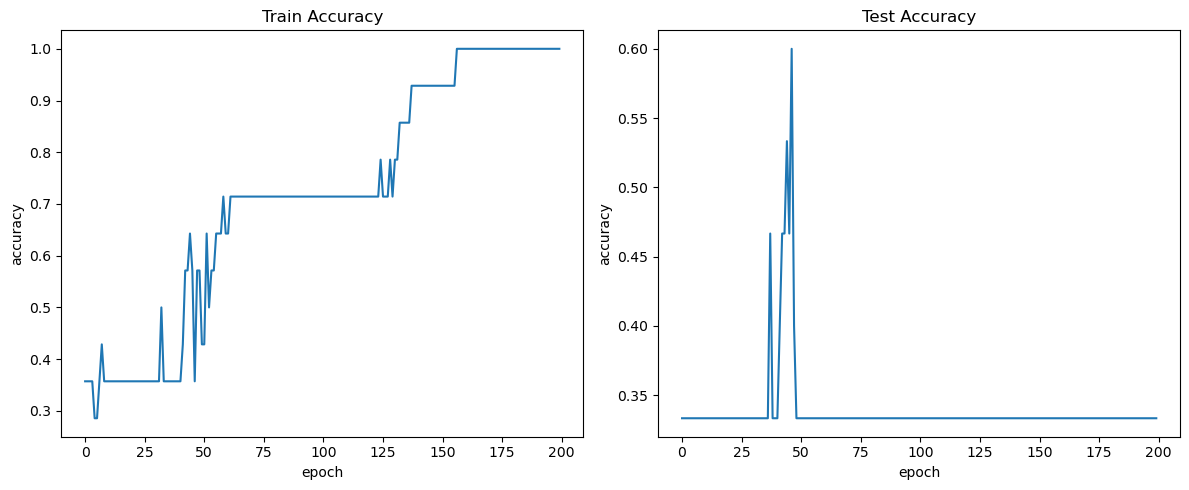

In [5]:
num_epochs = 200
best_model = None
best_accuracy = 0.0

optimizer = torch.optim.Adam(model.parameters(), lr=0.00075)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.3)
test_accuracy = []
train_accuracy = []
for epoch in range(num_epochs):
    model.train()
    for i, (x, y, l) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x, l)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    scheduler.step()

    model.eval()                         # 1) Switch to eval mode
    with torch.no_grad(): 
        test_predictions = torch.argmax(model(padded_x_test, test_lengths), dim=1)  # shape: [batch_size]
        test_correct_mask = (test_predictions == test_Y).to(torch.float32)
        test_acc = test_correct_mask.mean().item()               # get scalar value
        test_accuracy.append(test_acc)

        train_predictions = torch.argmax(model(padded_x_train, train_lengths), dim=1)
        train_correct_mask = (train_predictions == train_Y).to(torch.float32)
        train_acc = train_correct_mask.mean().item()
        train_accuracy.append(train_acc)

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = model.state_dict()


import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot train accuracy
ax1.set_title('Train Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.plot(train_accuracy)

# Plot test accuracy
ax2.set_title('Test Accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.plot(test_accuracy)

# Show the plots
plt.tight_layout()
plt.show()

